The code below should let us vizualise and see the matches.

In [1]:
import imageio
import numpy as np
import supersuit as ss
from stable_baselines3 import PPO
from ctf_env import CaptureTheFlagPZ

def record_match(red_model, blue_model, filename="match_replay.gif"):
    # 1. Setup Env with SAME wrappers as training
    env = CaptureTheFlagPZ(render_mode="rgb_array")
    
    # MUST match training wrappers
    env = ss.resize_v1(env, x_size=84, y_size=84)
    env = ss.color_reduction_v0(env, mode='full')
    env = ss.frame_stack_v1(env, 3)
    
    observations, infos = env.reset()
    frames = []
    
    print(f"Recording match to {filename}...")
    
    # PettingZoo Loop
    while env.agents:
        # Save the full render (not the tiny agent view)
        # We access the internal env to get the full high-res map
        # Use env.unwrapped.render() to use our custom multi-agent visualizer
        frames.append(env.unwrapped.render())
        
        actions = {}
        
        # Red Move
        if "red" in observations:
            # PPO expects a batch dimension, so we add [None] then [0]
            # deterministic=True means "Play your best move", not random
            act, _ = red_model.predict(observations["red"], deterministic=True)
            actions["red"] = act
            
        # Blue Move
        if "blue" in observations:
            act, _ = blue_model.predict(observations["blue"], deterministic=True)
            actions["blue"] = act
            
        observations, rewards, terms, truncs, infos = env.step(actions)

    # Save GIF
    imageio.mimsave(filename, frames, fps=10)
    print(f"Replay saved! ({len(frames)} frames)")


/home/alex/iths/minigridgroup/.venv/lib/python3.10/site-packages/pettingzoo/utils/conversions.py:320: UserWarning: The `infos` dictionary returned by `env.reset` was empty. OverwritingAgent IDs will be used as keys
  warnings.warn(


Recording match to self_play_match.gif...
Replay saved! (49 frames)


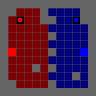

In [2]:
# --- RUN THE MATCH ---
# Load the model we just trained
# CRITICAL FIX: Added device="cpu"
champion_model = PPO.load("ctf_champion", device="cpu")

# Let the champion play against itself!
record_match(champion_model, champion_model, filename="self_play_match.gif")

from IPython.display import Image
display(Image(filename="self_play_match.gif"))

In [4]:
import time
import matplotlib.pyplot as plt
import supersuit as ss
from IPython.display import clear_output, display
from ctf_env import CaptureTheFlagPZ

# --- 1. SETUP ENVIRONMENT ---
env = CaptureTheFlagPZ(render_mode="rgb_array")
env = ss.resize_v1(env, x_size=84, y_size=84)
env = ss.color_reduction_v0(env, mode='full')
env = ss.frame_stack_v1(env, 3)

# --- 2. LIVE TOURNAMENT ---
wins = {"red": 0, "blue": 0, "draw": 0}
total_matches = 10

for i in range(total_matches):
    obs, _ = env.reset()
    done = False
    step_count = 0
    
    while not done:
        # 1. Get AI Actions
        # We check if the agent is in the observation to prevent KeyErrors
        if "red" in obs:
            act_red, _ = champion_model.predict(obs["red"], deterministic=True)
        if "blue" in obs:
            act_blue, _ = champion_model.predict(obs["blue"], deterministic=True)
        
        # 2. Step the Environment
        obs, rewards, terms, truncs, _ = env.step({"red": act_red, "blue": act_blue})
        step_count += 1
        
        # 3. RENDER LIVE
        frame = env.unwrapped.render()
        
        plt.figure(figsize=(6,6))
        plt.imshow(frame)
        plt.axis('off')
        
        # Status Strings
        r_status = "HAS FLAG!" if env.unwrapped.carrying_flag["red"] else ""
        b_status = "HAS FLAG!" if env.unwrapped.carrying_flag["blue"] else ""
        
        title_str = (f"MATCH {i+1} / {total_matches}\n"
                     f"Red: {wins['red']} {r_status}  vs  Blue: {wins['blue']} {b_status}\n"
                     f"Step: {step_count}")
        plt.title(title_str, fontsize=12, fontweight='bold')
        
        plt.show()
        
        # --- SPEED CONTROL ---
        time.sleep(0.01) 
        
        clear_output(wait=True)
        
        # 4. Check Game Over
        # FIX 1: Check if 'terms' (terminations) says the game is over
        if any(terms.values()) or any(truncs.values()):
            done = True
            
            # FIX 2: Use a lower threshold (5.0) to account for step penalties (9.99)
            if rewards.get("red", 0) > 5.0:
                wins["red"] += 1
                print(f"Match {i+1} Result: RED CAPTURED THE FLAG!")
                time.sleep(2)
            elif rewards.get("blue", 0) > 5.0:
                wins["blue"] += 1
                print(f"Match {i+1} Result: BLUE CAPTURED THE FLAG!")
                time.sleep(2)
            else:
                wins["draw"] += 1
                print(f"Match {i+1} Result: DRAW (Timeout)")
                time.sleep(1)

# --- FINAL RESULTS ---
print("="*30)
print("TOURNAMENT FINISHED")
print(f"Final Score: Red {wins['red']} - {wins['blue']} Blue")
print("="*30)

Match 10 Result: BLUE CAPTURED THE FLAG!
TOURNAMENT FINISHED
Final Score: Red 6 - 4 Blue
